In [1]:
import trimesh
import igl
import numpy as np
import random
import matplotlib.pyplot as plt
import open3d as o3d

In [2]:
def split_points(mesh_points):
    plane_origin_ = np.mean(mesh_points, 0)
    idx1 = random.randint(0, mesh_points.shape[0]-1)
    idx2 = random.randint(0, mesh_points.shape[0]-1)
    v1 = mesh_points[idx1]
    v2 = mesh_points[idx2]
    v_1 = (v1 - v2)/ np.linalg.norm(v1 - v2)
    idx1 = random.randint(0, mesh_points.shape[0]-1)
    idx2 = random.randint(0, mesh_points.shape[0]-1)
    v1 = mesh_points[idx1]
    v2 = mesh_points[idx2]
    v_2 = (v1- v2 )/ np.linalg.norm(v1 - v2)
    plane_normal_ = np.cross(v_1, v_2)
#             plane_origin_ = mesh.vertices[random.randint(0, len(mesh.vertices)-1)]
    pos_points = []
    neg_points = []
    for vertex in mesh_points:
        signed_distance =  np.dot(plane_normal_, np.subtract(vertex, plane_origin_))
        if signed_distance < 0:
            pos_points.append(vertex)
        else:
            neg_points.append(vertex)
    
    return np.array(pos_points), np.array(neg_points)

In [3]:
mesh = trimesh.load_mesh('./model_manifold.obj')
_,v_,f_,_,_ = igl.decimate(mesh.vertices,mesh.faces, 1500)
mesh_in = trimesh.Trimesh(v_, f_)

In [4]:
num_patches = 5


patches = [mesh_in.vertices]


while  len(patches)!=num_patches:
    mesh = patches.pop()
    p_, n_ = split_points(mesh)
    print('split done')
#     verts, faces  = get_verts_faces(p_)
#     p_ = trimesh.Trimesh(verts, faces)
#     verts, faces = get_verts_faces(n_)
#     n_ = trimesh.Trimesh(verts, faces)

    patches.insert(0, p_)
    patches.insert(0, n_)

split done
split done
split done
split done


In [5]:
patches[0].shape

(99, 3)

In [37]:
mesh_in.show()

/home/thor/anaconda3/envs/torchenv/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


(99, 3)
(90, 3)
(187, 3)
(160, 3)
(192, 3)


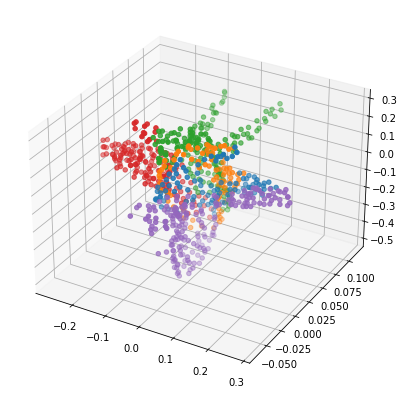

In [6]:
sum_ = 0
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for patch in patches:
    
# Creating plot
    print(patch.shape)
   
    ax.scatter3D(patch[:,0], patch[:,1], patch[:,2])

In [7]:
from sklearn.mixture import GaussianMixture

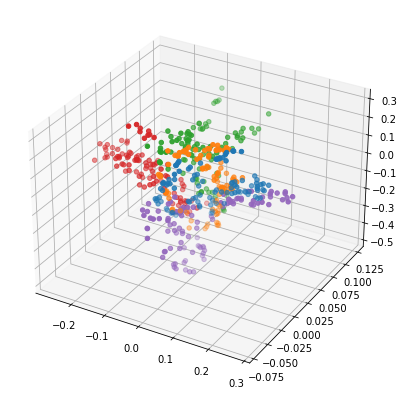

In [8]:
gmm_models = []
for patch in patches:
    model = GaussianMixture(n_components=20, random_state=0).fit(patch) # 20 optimal 5 so so 
#     print(model.means_.shape)
    gmm_models.append(model)

vertices = []
for i in range(len(gmm_models)):
    vertices.append(gmm_models[i].sample(100)[0])

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for vertex_set in vertices:
#     print(vertex_set.shape)
    ax.scatter3D(vertex_set[:,0], vertex_set[:,1], vertex_set[:,2])

In [9]:
new_v = np.array(vertices)
new_v = new_v.reshape(-1, 3)
print(new_v.shape)


(500, 3)


In [10]:
mesh = trimesh.Trimesh(np.array(new_v))


In [11]:
mesh.vertices.shape

(500, 3)

In [12]:
pcd  = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_v)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
        radius=0.1, max_nn=30))

In [13]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist

In [14]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [15]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]

In [34]:
bpa_tri_mesh = trimesh.Trimesh()
bpa_tri_mesh.vertices = bpa_mesh.vertices
bpa_tri_mesh.faces = bpa_mesh.triangles

poisson_tri_mesh = trimesh.Trimesh()
poisson_tri_mesh.vertices = poisson_mesh.vertices
poisson_tri_mesh.faces = poisson_mesh.triangles

In [22]:
%matplotlib inline

In [30]:
import meshplot as mp
import numpy as np

In [38]:
!pwd

/home/thor/IIITDPHD/graphics/SummerSchool2021/code


In [33]:
bpa_tri_mesh.show()

/home/thor/anaconda3/envs/torchenv/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [35]:
poisson_tri_mesh.show()

/home/thor/anaconda3/envs/torchenv/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [19]:
o3d.__version__

'0.13.0'

In [10]:
cov = gmm_models[0].covariances_
means = gmm_models[0].means_
weights = gmm_models[0].weights_
print(cov.shape)
print(means.shape)
print(weights.shape, weights.sum())

(20, 3, 3)
(20, 3)
(20,) 1.0000000000000004


In [11]:
cov[0]

array([[6.68715264e-06, 7.94775591e-06, 1.92788584e-06],
       [7.94775591e-06, 8.31763642e-05, 1.93746513e-05],
       [1.92788584e-06, 1.93746513e-05, 1.39079485e-04]])

In [12]:
import numpy as np

In [13]:
new_weights = np.cumsum(weights)

In [14]:
X = np.empty((100, means.shape[1]))
print(X.shape)

(100, 3)


In [15]:
from sklearn.utils import check_random_state

In [16]:
check_random_state(0)

RandomState(MT19937) at 0x7FA3C96D5678

In [17]:
random_state = check_random_state(gmm_models[0].random_state)

In [18]:
rand = random_state.rand(100)

In [19]:
comps = new_weights.searchsorted(rand)

In [20]:
comps

array([ 9, 13, 11,  9,  7, 12,  8, 17, 19,  7, 16,  9,  9, 18,  1,  1,  0,
       17, 15, 17, 19, 16,  8, 15,  1, 12,  2, 19,  8,  7,  5, 15,  8,  9,
        0, 11, 11, 11, 19, 12,  7,  8, 13,  1, 12, 12,  3,  1,  6,  7,  9,
        8, 19,  1,  3,  2, 12,  5,  8,  4,  2,  1, 12,  1,  3,  7, 16,  1,
       17,  1, 19,  8, 19, 11, 14,  0,  5,  1,  6,  1,  6,  7,  1, 13,  9,
        5,  8,  1,  9, 18,  6, 12,  1, 13,  5,  3, 10,  0, 17,  0])

In [21]:
comp_in_x = (0 == comps)

In [22]:
comp_in_x.sum()

5

In [23]:
gmm_models[0].covariance_type

'full'

In [24]:
from scipy import linalg

In [25]:
def sample_gaussian(mean, covar, covariance_type='diag', n_samples=1,
                    random_state=None):
 
    rng = check_random_state(random_state)
    n_dim = len(mean)
    rand = rng.randn(n_dim, n_samples)
    if n_samples == 1:
        rand.shape = (n_dim,)

    if covariance_type == 'spherical':
        rand *= np.sqrt(covar)
    elif covariance_type == 'diag':
        rand = np.dot(np.diag(np.sqrt(covar)), rand)
    else:
        s, U = linalg.eigh(covar)
        s.clip(0, out=s)        # get rid of tiny negatives
        np.sqrt(s, out=s)
        U *= s
        rand = np.dot(U, rand)

    return (rand.T + mean).T

In [26]:
cov.shape

(20, 3, 3)

In [27]:
means.shape

(20, 3)

In [28]:
comp = 0

In [29]:
X[comp_in_x] = sample_gaussian(means[comp], cov[comp] , 'full', random_state=random_state).T

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [37]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        conv1 = [nn.Conv1d(3, 64, kernel_size=1), 
                nn.BatchNorm1d(64),
                nn.ReLU()]
        conv2 = [nn.Conv1d(64, 128, kernel_size=1), 
                nn.BatchNorm1d(128),
                nn.ReLU()]
        conv3 = [nn.Conv1d(128, 256, kernel_size=1), 
                nn.BatchNorm1d(256),
                nn.ReLU()]
        conv4 = [nn.Conv1d(256, 128, kernel_size=1), 
                nn.BatchNorm1d(128),
                nn.AdaptiveMaxPool1d(1)]
        self.conv1 = nn.Sequential(*conv1)
        self.conv2 = nn.Sequential(*conv2)        
        self.conv3 = nn.Sequential(*conv3)
        self.conv4 = nn.Sequential(*conv4)
        
    def forward(self, x):
        out_1 = self.conv1(x)
        out_2 = self.conv2(out_1)
        out_3 = self.conv3(out_2)
        out_4 = self.conv4(out_3)
        print(out_4.shape)
        out_4 = out_4.view(-1, out_4.shape[1])
        print(out_4.shape)
        return out_4
    
    

class Decoder(nn.Module):
    def __init__(self, num_patches, n_components=5):
        super(Decoder, self).__init__()
        linear1 = [nn.Linear(128, 256), 
                nn.BatchNorm1d(256),
                nn.ReLU()]
        linear2 = [nn.Linear(256, 256), 
                nn.BatchNorm1d(256),
                nn.ReLU()]
        linear3 = [nn.Linear(256, 512), 
                nn.ReLU()]
        
        
        self.linear_mu = nn.Linear(512, num_patches*n_components*3)
        self.linear_sigma = nn.Linear(512, num_patches*n_components*9)
        self.linear_weights = nn.Linear(512, num_patches*n_components)
#         conv1 = nn.Conv1d(512, num_patches, 3, stride=1, padding=1)
#         conv1 = nn.Conv1d(128, , 3, stride=1, padding=1) # n weight, n * 3 mu, n * 3*3 sigma where n = num_components
        
        self.linear1 = nn.Sequential(*linear1)
        self.linear2 = nn.Sequential(*linear2)
        self.linear3 = nn.Sequential(*linear3)
        self.num_patches = num_patches
        self.n_components = n_components
    def forward(self, x):
        out_1 = self.linear1(x)
        out_2 = self.linear2(out_1)
        out_3 = self.linear3(out_2)
        
        mu = self.linear_mu(out_3)
        sigma = self.linear_sigma(out_3)
        weights = self.linear_weights(out_3).reshape(out_3.shape[0], self.num_patches, self.n_components)
        weights = F.softmax(weights, dim=-1)
        return mu, sigma, weights
    
    
class AutoEncoder(nn.Module):
    def __init__(self, num_patches, num_components=5):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(num_patches,num_components)
        
    def forward(self, x):
        out = self.encoder(x)
        mu, sigma, weights = self.decoder(out)
        
        return mu.reshape(mu.shape[0], self.decoder.num_patches, self.decoder.n_components, 3), \
            sigma.reshape(sigma.shape[0], self.decoder.num_patches, self.decoder.n_components, 3,3),\
            weights.reshape(weights.shape[0], self.decoder.num_patches, self.decoder.n_components)


In [38]:
x = torch.randn(2, 10, 1600, 3)
x = x.reshape(x.shape[0], -1, 3).permute(0,2,1).float()

In [39]:
x.shape

torch.Size([2, 3, 16000])

In [40]:
model = AutoEncoder(5)

In [41]:
mu, sigma, weights = model(x)

torch.Size([2, 128, 1])
torch.Size([2, 128])


In [42]:
print(mu.shape, sigma.shape, weights.shape)

torch.Size([2, 5, 5, 3]) torch.Size([2, 5, 5, 3, 3]) torch.Size([2, 5, 5])


In [44]:
import torch.distributions as D

In [46]:
normal = D.Normal?

In [49]:
mu[0].shape

torch.Size([5, 5, 3])

In [58]:
D.MultivariateNormal(torch.randn(2,3), torch.randn(2,3,3))

RuntimeError: cholesky_cpu: For batch 0: U(1,1) is zero, singular U.

In [59]:
normal = D.MultivariateNormal(mu[0].reshape(-1,3), sigma[0].reshape(-1,3,3))

RuntimeError: cholesky_cpu: For batch 0: U(2,2) is zero, singular U.

In [ ]:
distribution = torch.distributions.mixture_same_family.MixtureSameFamily()